# Python library Gensim

## Notebook Setup

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Obtain

In [21]:
df = pd.read_csv('raw_data.csv')
df['Response'] = df['How could ads aimed at you be improved?']
df = df.drop(['How could ads aimed at you be improved?','Count','Percentage'], axis=1)

In [22]:
df.head()

,Response
0,By using the real day woman that doesn't have ...
1,"Stop gender stereotyping, show more women in ..."
2,Be real without being patronising.
3,Don't assume all women fit into defined boxes
4,Not sure


# Scrub

In [23]:
tokens = []
for i in range(len(df['Response'])):
    tokens.append(gensim.utils.simple_preprocess(str(df['Response'][i]), deacc=True))

In [24]:
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokens], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [25]:
print(trigram_mod[bigram_mod[tokens[0]]])

['by', 'using', 'the', 'real', 'day', 'woman', 'that', 'doesn', 'have', 'perfect', 'figure', 'hair', 'and', 'skin']


In [26]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['use', 'real', 'day', 'woman', 'perfect', 'figure', 'hair', 'skin']]


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [29]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('day', 1),
  ('figure', 1),
  ('hair', 1),
  ('perfect', 1),
  ('real', 1),
  ('skin', 1),
  ('use', 1),
  ('woman', 1)]]

# Model

In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.047*"normal" + 0.034*"natural" + 0.023*"include" + 0.022*"sized" + '
  '0.018*"ordinary" + 0.017*"slim" + 0.016*"not" + 0.016*"good" + 0.015*"need" '
  '+ 0.015*"average"'),
 (1,
  '0.096*"model" + 0.073*"realistic" + 0.066*"less" + 0.063*"people" + '
  '0.029*"age" + 0.023*"life" + 0.015*"fashion" + 0.014*"clothe" + '
  '0.014*"colour" + 0.011*"celebrity"'),
 (2,
  '0.043*"nan" + 0.033*"big" + 0.030*"advertising" + 0.026*"product" + '
  '0.025*"would" + 0.019*"person" + 0.018*"really" + 0.016*"need" + '
  '0.015*"female" + 0.014*"none"'),
 (3,
  '0.204*"woman" + 0.045*"show" + 0.045*"size" + 0.031*"different" + '
  '0.029*"ad" + 0.024*"make" + 0.024*"body" + 0.021*"type" + 0.020*"use" + '
  '0.019*"shape"'),
 (4,
  '0.133*"real" + 0.034*"know" + 0.028*"stick" + 0.016*"diversity" + '
  '0.013*"always" + 0.013*"large" + 0.012*"girl" + 0.010*"still" + '
  '0.010*"figure" + 0.010*"want"')]


In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.413675013156621

Coherence Score:  0.5288063608434231


In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\chris\AppData\Local\Continuum\anaconda3\envs\gensim_env\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.310456  0.019058       1        1  42.661663
1     -0.055060 -0.259150       2        1  16.280539
4     -0.065329  0.103005       3        1  14.215175
0     -0.067685  0.060708       4        1  14.109717
2     -0.122382  0.076379       5        1  12.732905, topic_info=     Category        Freq           Term       Total  loglift  logprob
7     Default  385.000000          woman  385.000000  30.0000  30.0000
4     Default   82.000000           real   82.000000  29.0000  29.0000
36    Default   67.000000          model   67.000000  28.0000  28.0000
20    Default   51.000000      realistic   51.000000  27.0000  27.0000
47    Default   55.000000           less   55.000000  26.0000  26.0000
40    Default   51.000000         people   51.000000  25.0000  25.0000
70    Default   29.000000         normal   29.000000  24.0000  24.0000
23    Default   85.000000           show   85.000000  23.0000  23.0000
916   Default   24.000000            nan   24.000000  22.0000  22.0000
37    Default   85.000000           size   85.000000  21.0000  21.0000
76    Default   57.000000      different   57.000000  20.0000  20.0000
199   Default   21.000000           know   21.000000  19.0000  19.0000
188   Default   21.000000        natural   21.000000  18.0000  18.0000
41    Default   18.000000            big   18.000000  17.0000  17.0000
79    Default   53.000000             ad   53.000000  16.0000  16.0000
100   Default   32.000000            age   32.000000  15.0000  15.0000
332   Default   18.000000          stick   18.000000  14.0000  14.0000
234   Default   16.000000    advertising   16.000000  13.0000  13.0000
9     Default   44.000000           body   44.000000  12.0000  12.0000
254   Default   14.000000        product   14.000000  11.0000  11.0000
148   Default   16.000000           life   16.000000  10.0000  10.0000
87    Default   14.000000          would   14.000000   9.0000   9.0000
56    Default   45.000000           make   45.000000   8.0000   8.0000
27    Default   39.000000           type   39.000000   7.0000   7.0000
115   Default   14.000000        include   14.000000   6.0000   6.0000
277   Default   16.000000          sized   16.000000   5.0000   5.0000
22    Default   34.000000          shape   34.000000   4.0000   4.0000
282   Default   11.000000         person   11.000000   3.0000   3.0000
64    Default   21.000000           need   21.000000   2.0000   2.0000
661   Default   11.000000       ordinary   11.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
254    Topic5   14.221006        product   14.991634   2.0082  -3.6465
87     Topic5   13.545186          would   14.318221   2.0055  -3.6952
282    Topic5   10.386515         person   11.187707   1.9867  -3.9607
283    Topic5    9.917641         really   10.695860   1.9854  -4.0069
245    Topic5    7.922042         female    8.691205   1.9683  -4.2315
906    Topic5    7.669394           none    8.439362   1.9653  -4.2640
507    Topic5    6.989543           care    7.758296   1.9566  -4.3568
295    Topic5    6.598093      something    7.364277   1.9511  -4.4144
1030   Topic5    5.701270          enice    6.534159   1.9246  -4.5605
299    Topic5    4.899868         honest    5.667930   1.9154  -4.7120
341    Topic5    4.896232        empower    5.665785   1.9150  -4.7127
448    Topic5    4.847354  stereotypical    5.619431   1.9132  -4.7228
82     Topic5    4.597096             go    5.388296   1.9022  -4.7758
379    Topic5    3.205395       clothing    3.978217   1.8450  -5.1364
387    Topic5    3.179720       feminist    3.948617   1.8444  -5.1444
813    Topic5    2.897720          price    3.663119   1.8266  -5.2373
291    Topic5    2.915700       magazine    3.691154   1.8252  -5.2311
508    Topic5    2.924254       feminine    3.705260   1.8243  -5.2282
691    Topic5    2.890185    

In [34]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
    #    model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:33<00:00, 13.39s/it]


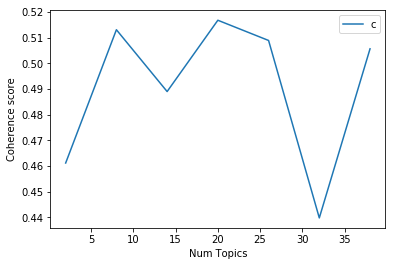

In [36]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Alternative Model

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/chris/OneDrive/flatiron/own_work/attest/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

NameError: name 'ldamallet' is not defined